In [5]:
import requests
import zipfile
import requests
import io
import zipfile
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
import html
from collections import defaultdict, Counter
import nltk
import re
from nltk.corpus import stopwords
stop_set = set(stopwords.words('english')) #create a set of english stopwords

In [7]:
#download data if we haven't already
if not os.path.isdir("nlp_data"): 
    url = "https://cs.stanford.edu/~myasu/projects/scisumm_net/scisummnet_release1.1__20190413.zip"
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zipObj:
       # Extract all the contents of zip file in different directory
       zipObj.extractall("nlp_data")
       print("File is unzipped in nlp_data folder") 
else:
    print("Data has already been downloaded")

Data has already been downloaded


In [8]:
#get all raw text, break all papers into two parts -- Abstract and rest of document

#first get all filepaths
xmlfiles = []
for subdir, dirs, files in os.walk(r'nlp_data'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".xml"):
            xmlfiles.append(filepath)




In [9]:
#next parse all XML documents

def parse_xml_abstract(fp):
    """ parse an XML journal article into an abstract and the rest of the text
    """
    try:
        tree = ET.parse(fp)
    except Exception as e:
        return "","",str(e)
    root = tree.getroot()
    
    ab = []
    bod = []
    
    for child in root:
        if child.tag == "ABSTRACT":
            for block in child:
                ab.append(block.text)
        else:
            for block in child:
                bod.append(block.text)
                
    #convert from list --> string
    abstract = "\n".join(ab)
    body = "\n".join(bod)
    
    #decode html entities
    abstract = html.unescape(abstract)
    body = html.unescape(body)
    
    return abstract,body,""

raw_cols = []
for fp in xmlfiles:
    ab,bod,err = parse_xml_abstract(fp)
    if err:
        #print(fp, err)
        continue
    raw_cols.append([ab,bod,fp])

df = pd.DataFrame(raw_cols, columns=["abstract", "body", "filepath"])
df

,abstract,body,filepath
0,We present a method for extracting parts of ob...,We present a method of extracting parts of obj...,nlp_data/scisummnet_release1.1__20190413/top10...
1,We describe a series of five statistical model...,We describe a series of five statistical model...,nlp_data/scisummnet_release1.1__20190413/top10...
2,Previous work has shown that Chinese word segm...,Word segmentation is considered an important f...,nlp_data/scisummnet_release1.1__20190413/top10...
3,We examine the viability of building large pol...,Polarity lexicons are large lists of phrases t...,nlp_data/scisummnet_release1.1__20190413/top10...
4,Extracting semantic relationships between enti...,Extraction of semantic relationships between e...,nlp_data/scisummnet_release1.1__20190413/top10...
...,...,...,...
1004,"In statistical machine translation, correspond...","In statistical machine translation, correspond...",nlp_data/scisummnet_release1.1__20190413/top10...
1005,We have developed a new program called alignin...,Aligning parallel texts has recently received ...,nlp_data/scisummnet_release1.1__20190413/top10...
1006,We present an approach to pronoun resolution b...,Pronoun resolution is a difficult but vital pa...,nlp_data/scisummnet_release1.1__20190413/top10...
1007,We use logical inference techniques for recogn...,Recognising textual entailment (RTE) is the ta...,nlp_data/scisummnet_release1.1__20190413/top10...


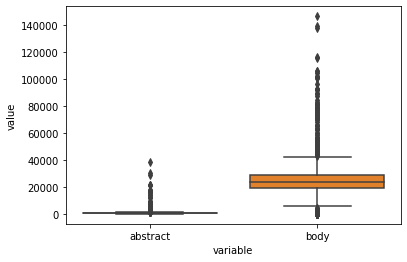

Average Abstract Length: 1084
Average Body Length: 26168


In [15]:
#find mean of abstracts body
#find total lengths

length_data = {
    "abstract":[],
    "body":[],
}

abstract_corpus = []
body_corpus = []

for index, row in df.iterrows():
    length_data["abstract"].append(len(row["abstract"]))
    length_data["body"].append(len(row["body"]))
    abstract_corpus.append(row["abstract"])
    body_corpus.append(row["body"])

ld = pd.DataFrame(length_data)
sns.boxplot(x="variable", y="value", data=pd.melt(ld))
plt.show()

def Average(lst): 
    return round(sum(lst) / len(lst)) 

print("Average Abstract Length: {}".format(Average(length_data["abstract"])))
print("Average Body Length: {}".format(Average(length_data["body"])))


<AxesSubplot:>

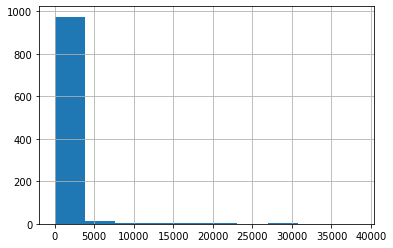

In [11]:
df['abstract'].str.len().hist()


<AxesSubplot:>

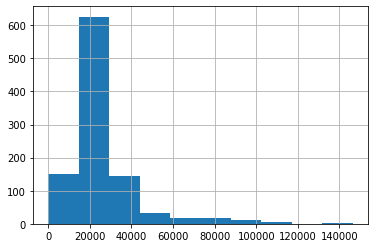

In [12]:
df['body'].str.len().hist()


<AxesSubplot:>

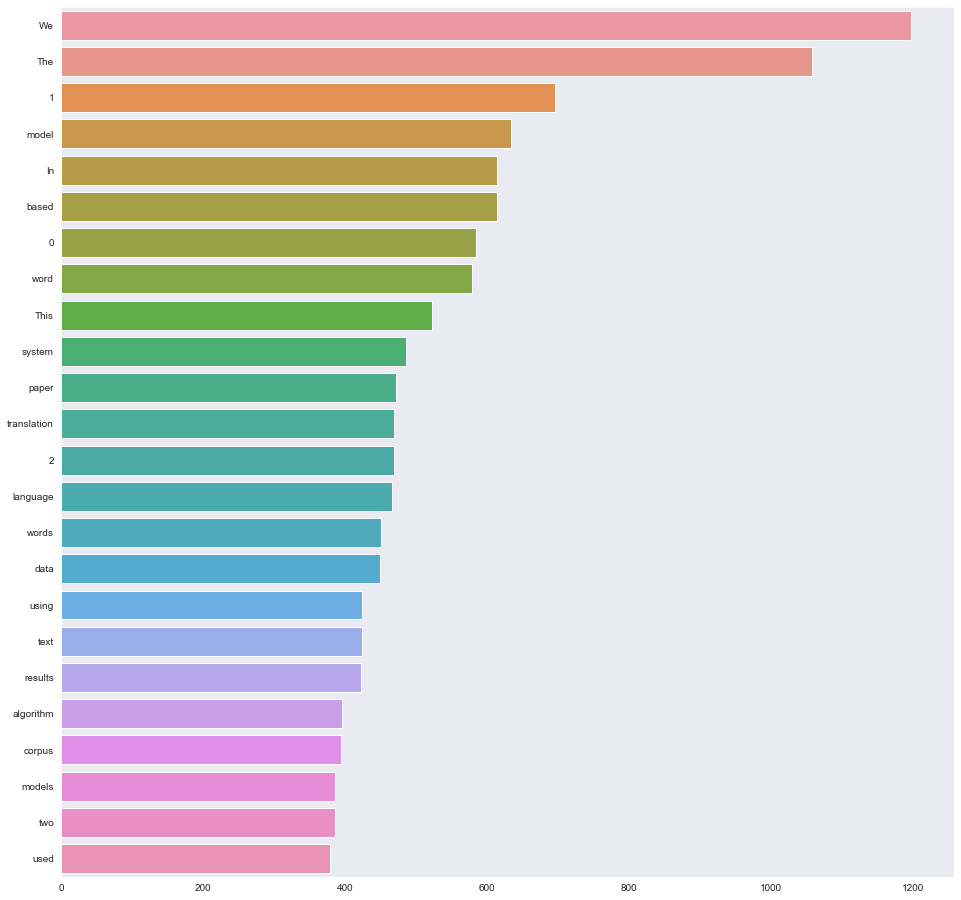

In [24]:
#find most common words in abstracts


abstract_words = re.findall(r"[\w']+", "\n".join(abstract_corpus))
counter = Counter(abstract_words)
most = counter.most_common()
x, y = [], []
for word,count in most[:50]:
    if (word not in stop_set):
        x.append(word)
        y.append(count)
sns.set_style("dark")
plot_dims = (16, 16)
fig, ax = plt.subplots(figsize=plot_dims)
sns.barplot(x=y,y=x)